In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression, Lasso
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import RandomForestClassifier

In [13]:
df = pd.read_csv('D:/features_selection/data_sample/LoanDataset - LoansDatasest.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32586 entries, 0 to 32585
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_id          32583 non-null  float64
 1   customer_age         32586 non-null  int64  
 2   customer_income      32586 non-null  object 
 3   home_ownership       32586 non-null  object 
 4   employment_duration  31691 non-null  float64
 5   loan_intent          32586 non-null  object 
 6   loan_grade           32586 non-null  object 
 7   loan_amnt            32585 non-null  object 
 8   loan_int_rate        29470 non-null  float64
 9   term_years           32586 non-null  int64  
 10  historical_default   11849 non-null  object 
 11  cred_hist_length     32586 non-null  int64  
 12  Current_loan_status  32582 non-null  object 
dtypes: float64(3), int64(3), object(7)
memory usage: 3.2+ MB


In [14]:
df = df.drop(['customer_id','employment_duration','cred_hist_length'], axis=1)

# Xử lý dữ liệu không hợp lệ: loại bỏ ký hiệu tiền tệ
df['loan_amnt'] = df['loan_amnt'].replace('[\£,]', '', regex=True).astype(float)

# xóa dấu dữ liệu trong cột customer_income và đổi định dạng float
df['customer_income'] = df['customer_income'].replace(',', '', regex=True).astype(float)

In [15]:
# Mã hóa các biến phân loại
label_encoder = LabelEncoder()
for column in ['home_ownership', 'loan_intent', 'loan_grade', 'historical_default']:
    df[column] = label_encoder.fit_transform(df[column])

# Xử lý biến mục tiêu
df['Current_loan_status'] = df['Current_loan_status'].apply(lambda x: 0 if x == 'NO DEFAULT' else 1)

# Xử lý giá trị thiếu bằng cách điền giá trị trung vị
#df.fillna(df.median(), inplace=True)


print (df.head(15))


    customer_age  customer_income  home_ownership  loan_intent  loan_grade  \
0             22          59000.0               3            4           2   
1             21           9600.0               2            1           0   
2             25           9600.0               0            3           1   
3             23          65500.0               3            3           1   
4             24          54400.0               3            3           1   
5             21           9900.0               2            5           0   
6             26          77100.0               3            1           0   
7             24          78956.0               3            3           0   
8             24          83000.0               3            4           0   
9             21          10000.0               2            5           2   
10            22          85000.0               3            5           0   
11            21          10000.0               2            2  

### Chọn Features dựa vào mô hình học máy Random Forest

In [16]:
features = ['customer_age','customer_income','home_ownership','loan_intent','loan_grade','loan_amnt','loan_int_rate','term_years','historical_default']
target = ['Current_loan_status']
# Xác định feature X và biến mục tiêu y
X = df[features]
y = df[target]

# Khởi tạo biến train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuẩn hoá dữ liệu trong khoảng từ [0;1]
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Chuyển đổi y_train và y_test sang mảng 1 chiều
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [17]:
# Huấn luyện mô hình Random Forest
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = clf.predict(X_test)

# Feature importances
feat_importances = pd.Series(clf.feature_importances_, index=features)

# Kiểm tra giá trị của feature importances
print("Feature Importances:\n", feat_importances)

# Chọn features_importance của RF (điểm đánh giá > 0.05)
important_features_RF = [features[i] for i in range(len(features)) if feat_importances.iloc[i] > 0.05]
print("Important Features:", important_features_RF)

Feature Importances:
 customer_age          0.109987
customer_income       0.105559
home_ownership        0.039233
loan_intent           0.037202
loan_grade            0.060475
loan_amnt             0.060737
loan_int_rate         0.098892
term_years            0.020841
historical_default    0.467076
dtype: float64
Important Features: ['customer_age', 'customer_income', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'historical_default']


C:\Users\TIDUS\AppData\Local\Temp\ipykernel_9648\3327162082.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  important_indices = [i for i in range(len(features)) if feat_importances[i] > 0.05]
C:\Users\TIDUS\AppData\Local\Temp\ipykernel_9648\3327162082.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sns.barplot(x=[features[i] for i in important_indices], y=[feat_importances[i] for i in important_indices])


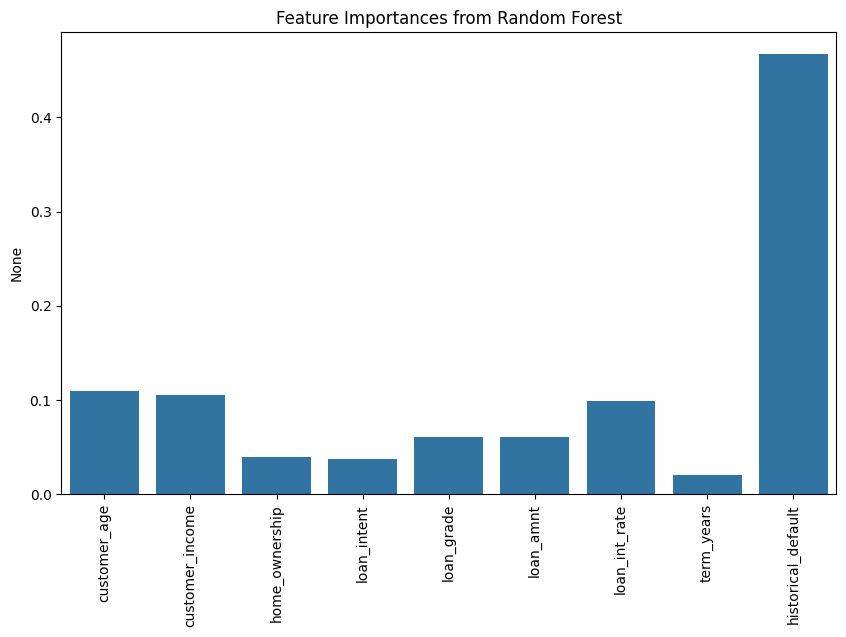

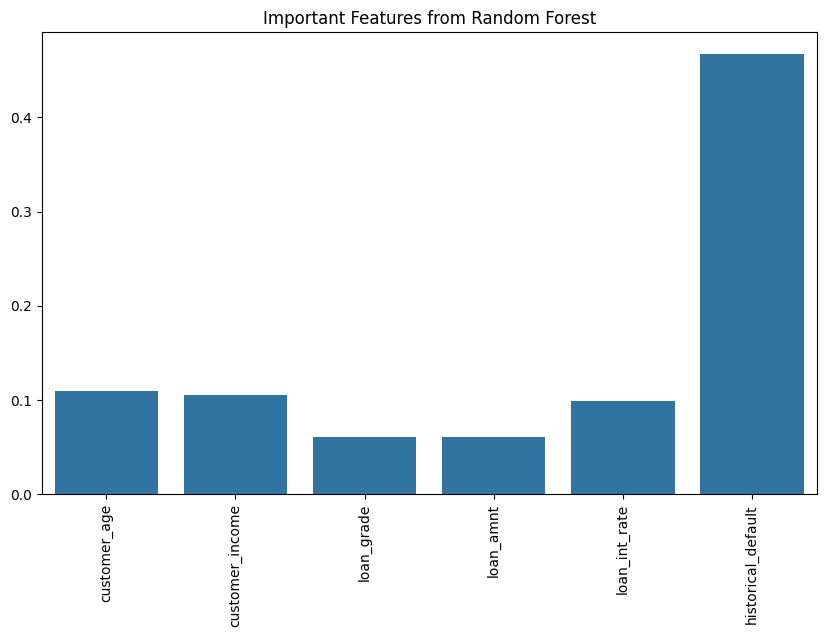

In [18]:
# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=features, y=feat_importances)
plt.xticks(rotation=90)
plt.title('Feature Importances from Random Forest')
plt.savefig("D:/features_selection/image/RF/ft.png")

# Plot only important features
important_indices = [i for i in range(len(features)) if feat_importances[i] > 0.05]
plt.figure(figsize=(10, 6))
sns.barplot(x=[features[i] for i in important_indices], y=[feat_importances[i] for i in important_indices])
plt.xticks(rotation=90)
plt.title('Important Features from Random Forest')
plt.savefig("D:/features_selection/image/RF/Im_ft.png")

## Chọn Features dựa vào tính tương quan của ma trận

Important Features from Correlation: ['historical_default', 'loan_grade', 'loan_int_rate', 'home_ownership', 'customer_income', 'loan_intent']


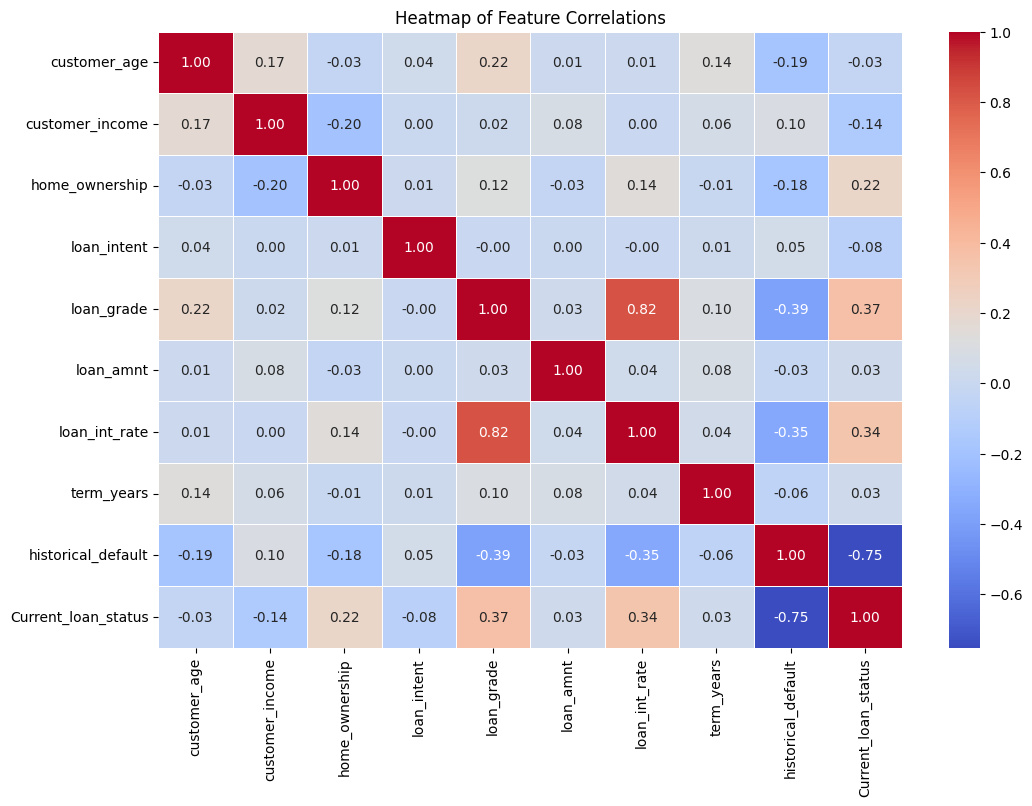

In [19]:
# Tính toán ma trận tương quan
corr_matrix = df.corr()

# Hiển thị ma trận tương quan
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap of Feature Correlations')
plt.savefig('D:/features_selection/image/Matrix/matrix.png')

# Chọn các features có tương quan với biến target (Current_loan_status)
correlation_threshold = 0.05
important_features = corr_matrix['Current_loan_status'].abs().sort_values(ascending=False)
selected_features = important_features[important_features > correlation_threshold].index.tolist()
selected_features.remove('Current_loan_status')
print("Important Features from Correlation:", selected_features)

### Random Forest vs mô hình máy học chọn features của RF

Accuracy: 0.9441546486652347
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      5142
           1       0.89      0.84      0.86      1376

    accuracy                           0.94      6518
   macro avg       0.92      0.91      0.91      6518
weighted avg       0.94      0.94      0.94      6518

thời gian thực hiện của RF là: 1.6831090450286865 s


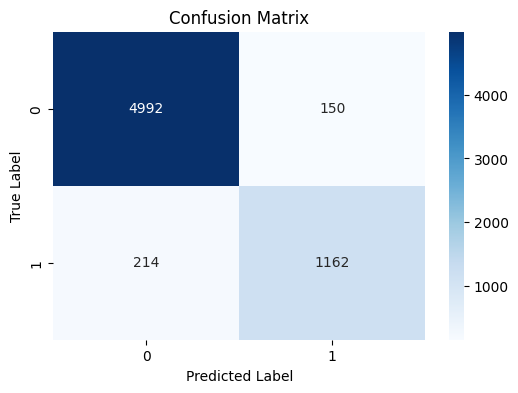

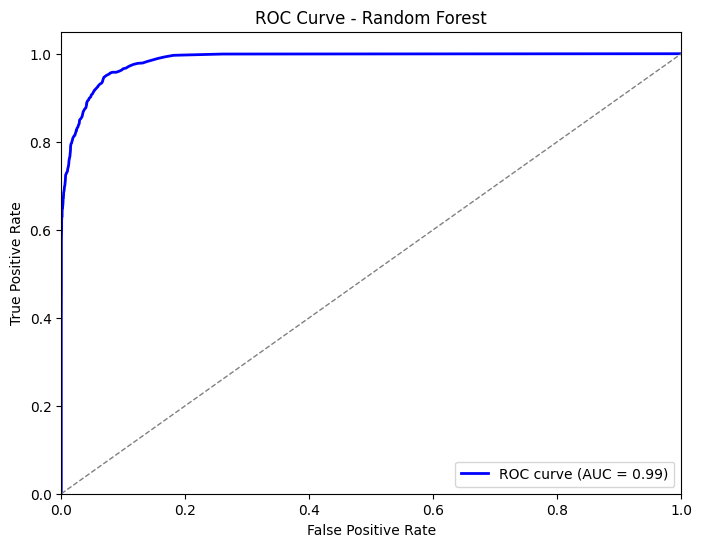

In [30]:
# Xác định feature X và biến mục tiêu y
X = df[important_features_RF]
y = df[target]

# Khởi tạo biến train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuẩn hoá dữ liệu trong khoảng từ [0;1]
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Chuyển đổi y_train và y_test sang mảng 1 chiều
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()


#RF

#check time
start_timeRF = time.time()
###### Huấn luyện mô hình Random Forest
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = clf.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('D:/features_selection/image/RF/matrix_RF.png')

# Tính toán dự đoán xác suất từ mô hình Random Forest
y_pred_proba_rf = clf.predict_proba(X_test)[:,1]

# Tính toán đường cong ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

# Tính toán diện tích dưới đường cong ROC (AUC)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

# Vẽ đường cong ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_rf))
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.savefig('D:/features_selection/image/RF/ROC_RF.png')

#end_time
end_timeRF = time.time()

#caculator_time
execution_timeRF = end_timeRF - start_timeRF

print('thời gian thực hiện của RF là:',execution_timeRF,"s")

### Random Forest với chọn features bằng tính tương quan

Accuracy: 0.934949370972691
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5142
           1       0.86      0.83      0.84      1376

    accuracy                           0.93      6518
   macro avg       0.91      0.90      0.90      6518
weighted avg       0.93      0.93      0.93      6518

thời gian thực hiện của RF là: 1.5190889835357666 s


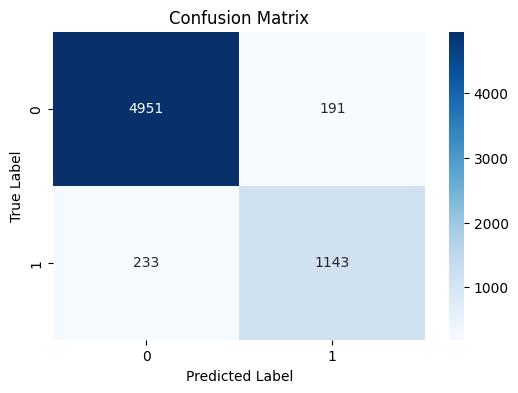

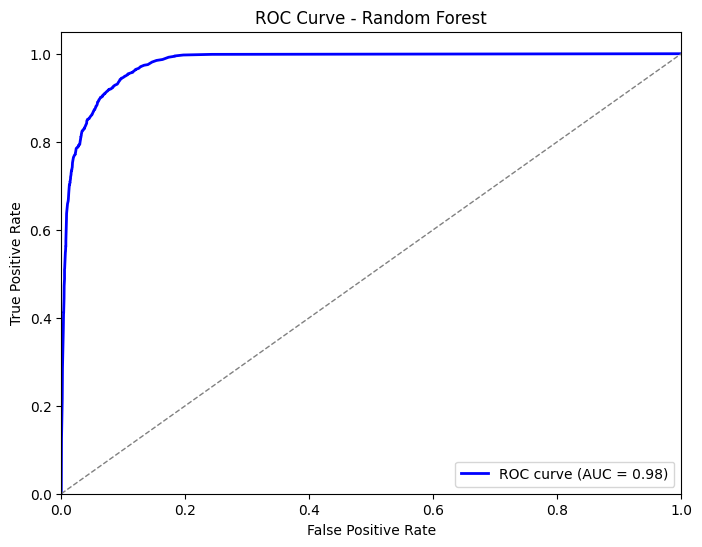

In [29]:
# Xác định feature X và biến mục tiêu y
X = df[selected_features]
y = df[target]

# Khởi tạo biến train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuẩn hoá dữ liệu trong khoảng từ [0;1]
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Chuyển đổi y_train và y_test sang mảng 1 chiều
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()


#RF

#check time
start_timeRF = time.time()
###### Huấn luyện mô hình Random Forest
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = clf.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('D:/features_selection/image/matrix/matrix_confusion_tq.png')

# Tính toán dự đoán xác suất từ mô hình Random Forest
y_pred_proba_rf = clf.predict_proba(X_test)[:,1]

# Tính toán đường cong ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

# Tính toán diện tích dưới đường cong ROC (AUC)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

# Vẽ đường cong ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_rf))
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.savefig('D:/features_selection/image/matrix/ROC_tq.png')

#end_time
end_timeRF = time.time()

#caculator_time
execution_timeRF = end_timeRF - start_timeRF

print('thời gian thực hiện của RF là:',execution_timeRF,"s")

# Không chọn Features_Importance

In [34]:
features = ['customer_age','customer_income','home_ownership','loan_intent','loan_grade','loan_amnt','loan_int_rate','term_years','historical_default']
target = ['Current_loan_status']
# Xác định feature X và biến mục tiêu y
X = df[features]
y = df[target]

# Khởi tạo biến train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuẩn hoá dữ liệu trong khoảng từ [0;1]
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Chuyển đổi y_train và y_test sang mảng 1 chiều
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

Accuracy: 0.9670144216017184
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5142
           1       0.93      0.91      0.92      1376

    accuracy                           0.97      6518
   macro avg       0.95      0.95      0.95      6518
weighted avg       0.97      0.97      0.97      6518

thời gian thực hiện của RF là: 2.1523375511169434 s


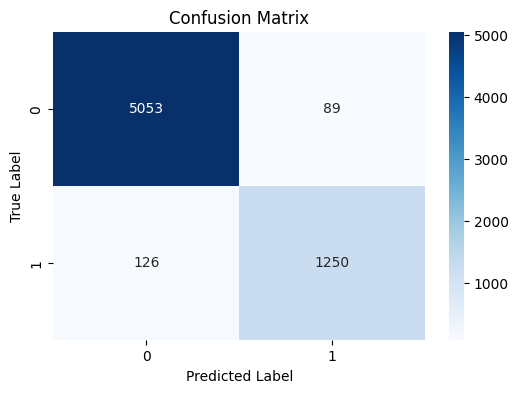

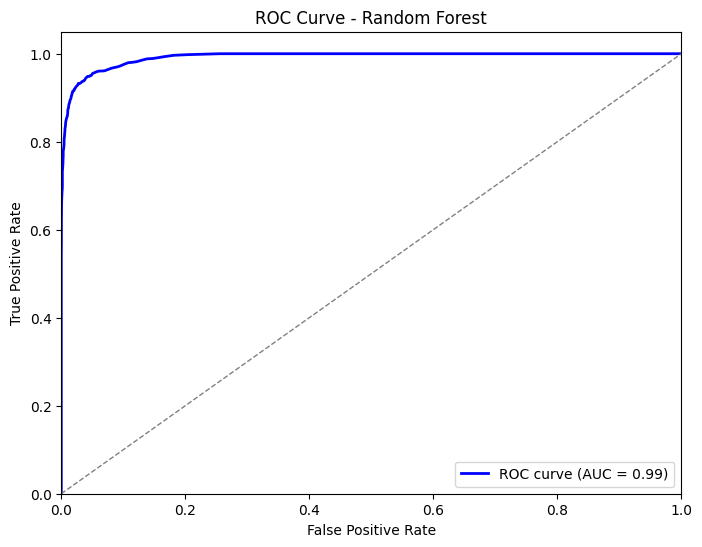

In [35]:
#RF

#check time
start_timeRF = time.time()
###### Huấn luyện mô hình Random Forest
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = clf.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('D:/features_selection/image/No_imp_ft/cf_matrix_no_ft.png')

# Tính toán dự đoán xác suất từ mô hình Random Forest
y_pred_proba_rf = clf.predict_proba(X_test)[:,1]

# Tính toán đường cong ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

# Tính toán diện tích dưới đường cong ROC (AUC)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

# Vẽ đường cong ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_rf))
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.savefig('D:/features_selection/image/No_imp_ft/ROC_no_ft.png')

#end_time
end_timeRF = time.time()

#caculator_time
execution_timeRF = end_timeRF - start_timeRF

print('thời gian thực hiện của RF là:',execution_timeRF,"s")